In [1]:
setwd('/data/jzr5814/repositories/DnDs-visualization/Hierarchical_Edge_Bundling_tree/GTDB')

In [2]:
# Switch to R
library(tidyverse)
library(viridis)
library(patchwork)
library(ggraph)
library(igraph)
library(RColorBrewer)
library(dplyr)
library(tidyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following

In [3]:
# Step1: Read in the raw taxonomy files for both Archaea and Bacteria
# Taxonomy for Archaea (Read in the raw taxonomy file)
archaea_taxonomy_raw <- read.csv('GTDB_taxonomy/ar53_taxonomy_r214.tsv', sep = '\t', header = FALSE)
colnames(archaea_taxonomy_raw) <- c('Assembly ID', 'lineage')

# Taxonomy for Bacteria (Read in the raw taxonomy file)
bacteria_taxonomy_raw <- read.csv('GTDB_taxonomy/bac120_taxonomy_r214.tsv', sep = '\t', header = FALSE)
colnames(bacteria_taxonomy_raw) <- c('Assembly ID', 'lineage')

In [4]:
# Step 2: Clean the archaea taxonomy raw data
archaea_taxonomy <- archaea_taxonomy_raw %>%
  mutate(`Assembly ID` = gsub("^.{2}_", "", `Assembly ID`)) %>%  # Remove first two characters and underscore
  mutate(root = "Root") %>%  # Add the "root" column with all values as "Root"
  relocate(root, .after = `Assembly ID`) %>%  # Place the "root" column after "Assembly ID"
  separate(lineage, into = c("superkingdom", "phylum", "class", "order", "family", "genus", "species"),
           sep = ";", remove = TRUE) %>%  # Split lineage into taxonomy columns
  mutate(across(superkingdom:species, ~ gsub("^[dpcfogs]__", "", .)))

# Clean the bacteria taxonomy raw data
bacteria_taxonomy <- bacteria_taxonomy_raw %>%
  mutate(`Assembly ID` = gsub("^.{2}_", "", `Assembly ID`)) %>%  # Remove first two characters and underscore
  mutate(root = "Root") %>%  # Add the "root" column with all values as "Root"
  relocate(root, .after = `Assembly ID`) %>%  # Place the "root" column after "Assembly ID"
  separate(lineage, into = c("superkingdom", "phylum", "class", "order", "family", "genus", "species"),
           sep = ";", remove = TRUE) %>%  # Split lineage into taxonomy columns
  mutate(across(superkingdom:species, ~ gsub("^[dpcfogs]__", "", .)))

# Append the archaea and bacteria taxonomy data
lineage_information_new <- rbind(archaea_taxonomy, bacteria_taxonomy)

In [5]:
# Export to CSV
write.csv(lineage_information_new, file = "lineage_information_jzr.csv", row.names = FALSE, quote = FALSE)

In [16]:
# Step 3: Clean the 'query_name_x' and 'match_name_x' columns in the 'fmh_omega_7' dataset

# Define file path
file_path <- "/data/jzr5814/sourmash_dnds_estimation/for_jinglin/fmh_omega_7.csv"

# Read the CSV file
fmh_omega_7 <- read.csv(file_path, sep = ",", header = TRUE)
#fmh_omega_7

# Modify 'query_name_x' and 'match_name_x' columns to remove the first two characters and underscore
fmh_omega_7$query_name <- sapply(strsplit(as.character(fmh_omega_7$query_name), "_"), function(x) paste(x[-1], collapse = "_"))
fmh_omega_7$match_name <- sapply(strsplit(as.character(fmh_omega_7$match_name), "_"), function(x) paste(x[-1], collapse = "_"))
#fmh_omega_7

# Filter rows where 'query_name_x' and 'match_name_x' are in the column "Assembly ID" of lineage_information_new
fmh_omega_7_short <- fmh_omega_7[
  fmh_omega_7$query_name %in% lineage_information_new$`Assembly ID` &
  fmh_omega_7$match_name %in% lineage_information_new$`Assembly ID`,
]

# Select specific columns: 'query_name_x', 'match_name_x', and 'dN/dS'
fmh_omega_7_short <- fmh_omega_7_short[, c("query_name", "match_name", "dN.dS")]


In [17]:
# Export to CSV
write.csv(fmh_omega_7_short, file = "fmh_omega_7_short_jzr.csv", row.names = FALSE, quote = FALSE)

In [23]:
# Step 4: Clean taxonomy and dnds datasets, selecting columns that are needed
taxonomy <- read.csv('lineage_information_jzr.csv')
dnds <- read.csv('fmh_omega_7_short_jzr.csv')

dnds <- dnds %>%
  filter(!is.na(dN.dS)) %>%
  rename(from = query_name, to = match_name, dndsvalue = dN.dS) %>%
  select(from, to, dndsvalue)


# Keep only Assembly.ID present in dnds$query_name_x or dnds$match_name_x
taxonomy_selected <- taxonomy %>%
  filter(Assembly.ID %in% unique(c(dnds$from, dnds$to)))


In [24]:
# # Step 5: Check for mutual pairs such as from genome A to genome B and from genome B to genome A in dnds dataset
mutual_check <- merge(dnds, dnds, by.x = c("from", "to"), by.y = c("to", "from"))

# Output the result
if (nrow(mutual_check) > 0) {
  print("Mutual connections found:")
  print(mutual_check)
} else {
  print("No mutual connections found.")
}

[1] "No mutual connections found."


In [25]:
# # Step 6: # Find out all genomes ids that are in the isolated pair. 
# The isolated pair here means each genome in this pair only connects to other genomes that only exists in this pair

# Create an undirected graph from the edge list
g <- graph_from_data_frame(dnds, directed = FALSE)

# Find connected components
comps <- components(g)

# Get component sizes
component_sizes <- comps$csize

# Get the membership vector
membership <- comps$membership

# Find components of size 2 (which connects with one and only one other genome)
components_of_size_two <- which(component_sizes == 2)

# Initialize vector to store genome IDs in isolated pairs
isolated_genomes <- c()

# Loop through each component of size 2
for (comp in components_of_size_two) {
  # Get the nodes in this component
  nodes_in_comp <- names(membership[membership == comp])
  # Add them to isolated_genomes
  isolated_genomes <- c(isolated_genomes, nodes_in_comp)
}

# Remove duplicate entries
isolated_genomes <- unique(isolated_genomes)


In [73]:
# # Step 7: # Based on the dnds dataset, removing all species that contained isolated_genomes ID in Step 6 
# since we do not want to show gemones that connects only one another genome in the visualization
# filter dnds to keep the visulation clean
# connect <- dnds[!(dnds$from %in% isolated_genomes), ] %>%
  # filter((dndsvalue >= 0.7 & dndsvalue <= 0.9 | dndsvalue >= 1.1 & dndsvalue <= 3))
  # filter(dndsvalue > 0.8 & dndsvalue < 1)
  # filter(dndsvalue > 1)
  # filter(dndsvalue >= 1.1 & dndsvalue <= 2)


# Let's randomly sort so that the dataset isnt so big
# Step 1: Filter to exclude isolated genomes
connect_temp <- dnds[!(dnds$from %in% isolated_genomes), ]

# Step 2: Randomly select 50 rows for each dnds range
set1 <- connect_temp %>%
  filter(dndsvalue >= 0.4, dndsvalue <= 0.9) %>%
  sample_n(40)

set2 <- connect_temp %>%
  filter(dndsvalue >= 1.1, dndsvalue <= 2) %>%
  sample_n(40)

# Step 3: Combine the two sets
connect <- bind_rows(set1, set2)

# (Optional) View
#connect

  

In [74]:
# Step 8: Merge taxonomy information with the 'connect' dataset to 
# ensure both genome A and genome B have taxonomy information for a given taxonomic level such as genus

# Merge taxonomy information for the 'from' column
connect_with_from <- connect %>%
  left_join(taxonomy_selected, by = c("from" = "Assembly.ID")) %>%
  rename(root_from = root, 
         superkingdom_from = superkingdom, 
         phylum_from = phylum, 
         class_from = class, 
         order_from = order, 
         family_from = family, 
         genus_from = genus, 
         species_from = species)

# Merge taxonomy information for the 'to' column
connect_with_taxonomy <- connect_with_from %>%
  left_join(taxonomy_selected, by = c("to" = "Assembly.ID")) %>%
  rename(root_to = root, 
         superkingdom_to = superkingdom, 
         phylum_to = phylum, 
         class_to = class, 
         order_to = order, 
         family_to = family, 
         genus_to = genus, 
         species_to = species)

connect_with_taxonomy_updated<-connect_with_taxonomy %>%
  filter(genus_from != "" & !is.na(genus_from),  # Ensure genus_from is not empty or NA
         genus_to != "" & !is.na(genus_to), # Ensure genus_to is not empty or NA
         superkingdom_from == superkingdom_to # Ensure the superkingdoms are the same
        #  superkingdom_from == 'Bacteria' &  superkingdom_to == 'Bacteria'   # Ensure both superkingdom_from and superkingdom_to are 'Bacteria'
        #  superkingdom_from == 'Archaea' &  superkingdom_to == 'Archaea'   # Ensure both superkingdom_from and superkingdom_to are 'Archaea'
         
         ) 

cat("Number of valid edges (with positions):", nrow(connect_with_taxonomy_updated), "\n")

Number of valid edges (with positions): 80 


In [75]:
connect_with_taxonomy_updated_same_genus <- connect_with_taxonomy_updated %>%
    filter(genus_from == genus_to)  %>%
    arrange(genus_from)

# write to csv
write.csv(connect_with_taxonomy_updated_same_genus, file = "dnds_0.8_1_same_genus_jzr.csv", row.names = FALSE, quote = FALSE)



In [76]:
# Step 9: Clean the taxonomy_selected df to keep only the nodes (valid nodes) that are present 
# in the filtered connect df in Step 8
taxonomy_selected_final <- taxonomy_selected[taxonomy_selected$Assembly.ID %in% unique(c(connect_with_taxonomy_updated$from, connect_with_taxonomy_updated$to)), ]
cat("Number of valid nodes:", nrow(taxonomy_selected_final), "\n")


Number of valid nodes: 151 


In [77]:
# Step 10: Create hierarcy and vertices for hierarchical edge bundling visualization

# Add a root column to the taxonomy data, reshape the data into long format
taxonomy_long <- taxonomy_selected_final %>%
  select(Assembly.ID, root, superkingdom, phylum, class, order, family, genus, species) %>%
  mutate(root = if_else(root == "cellular organisms", "Root", root)) %>%
      # Create hierarchical relationships
  pivot_longer(cols = c(root, superkingdom, phylum, class, order, family, genus, species, Assembly.ID),
               names_to = "level",
               values_to = "name") %>%
  mutate(genome_id = rep(taxonomy_selected_final$Assembly.ID, each = 9)) # 9 is the numbers of columns in taxonomy_selected

  # Create hierarchical relationships
hierarchy <- taxonomy_long %>%

  # sorting taxomomic level within each genome ("genome_id")
  arrange(genome_id, match(level, c("root", "superkingdom", "phylum", "class", "order", "family", "genus", "species", "Assembly.ID"))) %>%
  group_by(genome_id) %>%

  # from = lag(name): Take the value from the previous row in the column "name" and assigns it to a new column called from, 
  # to = name: Set the value in column "to" the value in the name column.
  mutate(from = lag(name), to = name)  %>%
  filter(!is.na(from)) %>%
  select(from, to, genome_id) %>%
  distinct() %>%
  ungroup() %>%
  distinct(from, to)

vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))))
nrow(vertices)

[1] 518

In [78]:
# Attempt 1:
set.seed(399)
library(ggraph)
library(igraph)
library(dplyr)


# Create the graph object
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))), value = runif(nrow(vertices))) 
mygraph <- graph_from_data_frame(hierarchy, vertices = vertices)


from <- match(connect_with_taxonomy_updated$from, vertices$name)
to <- match(connect_with_taxonomy_updated$to, vertices$name)

In [89]:
# Step 11: Retain layout data for only the nodes that are connected by valid edges
# create the layout so we can feed to to get_con and manipulate the data frame directly for plotting
layout_data <- create_layout(mygraph, layout = 'dendrogram', circular = TRUE)

# # 'from' and 'to' are vectors of node indices or names
conn_function <- get_con(from = from, to = to)
conn_data_frame <- conn_function(layout_data)
edges <- conn_data_frame


# # # Add connection values to `conn_data_frame`. This is one of the key steps of getting the connections/dNdS values to match up with the actual plot
conn_data_frame$con.value <- connect_with_taxonomy_updated$dndsvalue[conn_data_frame$con.id]

# Remove invalid connections where genomes are not in connect_new
conn_data_frame <- conn_data_frame[!is.na(conn_data_frame$con.value), ]

sum(conn_data_frame$leaf == 'TRUE')

[1] 160

In [90]:
# Step 12: Determine the coordinates of the genus label
genome_coordinate<-unique(conn_data_frame[conn_data_frame$leaf == TRUE, c('name','x','y')])

genome_coordinate_info <- merge(
  genome_coordinate, 
  taxonomy_selected_final[, c("Assembly.ID", "phylum", "class", "order", "family", "genus", "species")],
  by.x = "name", 
  by.y = "Assembly.ID", 
  all.x = TRUE
)

# Function to calculate center coordinates for each genus
calculate_genus_centers <- function(data, taxonomy_level_column, x_column, y_column) {
  # Group by genus and calculate the mean x and y coordinates
  centers <- data %>%
    group_by(!!sym(taxonomy_level_column)) %>%
    summarise(
      center_x = mean(!!sym(x_column)),
      center_y = mean(!!sym(y_column)),
      .groups = 'drop'
    )
  return(centers)
}

taxonomy_level_column<-"genus" # Can change to any other taxonomy levels such as family


# Dynamically create the name for genus_centers
centers_name <- paste0(taxonomy_level_column, "_centers")

# Calculate centers and assign to dynamically named variable
assign(centers_name, calculate_genus_centers(genome_coordinate_info, 
                                             taxonomy_level_column = taxonomy_level_column, 
                                             x_column = "x", 
                                             y_column = "y"))

# nrow(genus_centers)

cat("Number of unique", taxonomy_level_column, "groups:", nrow(genus_centers), "\n")

Number of unique genus groups: 83 


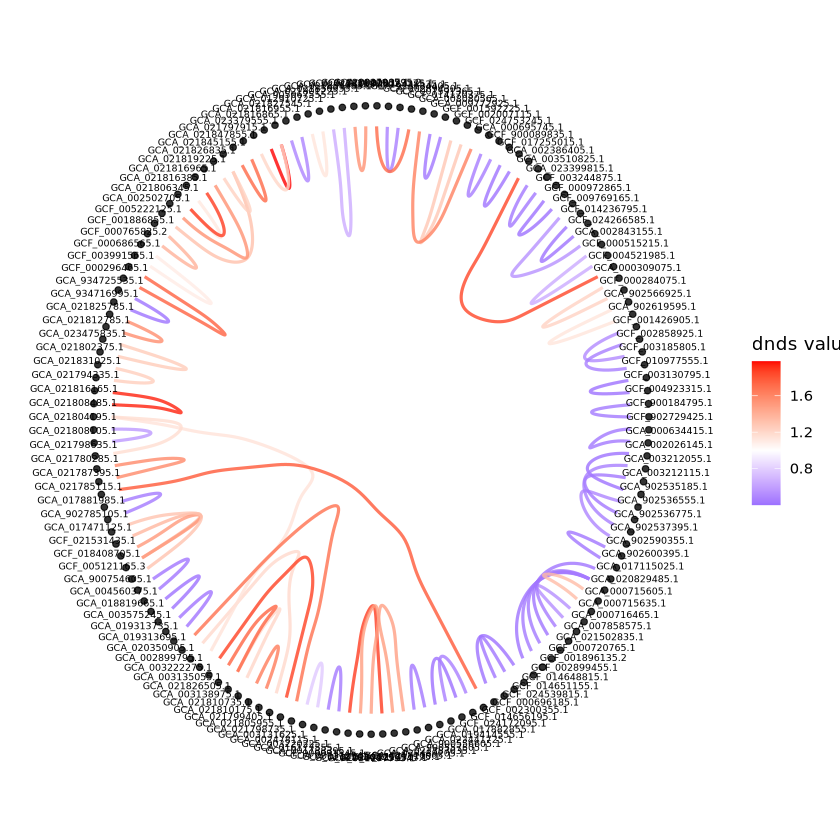

In [138]:
# Step 13a: Generate a graph based on genomes and their dN/dS values, labelling each dot on the circle represents a genome
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(
    data = conn_data_frame, 
    alpha = 0.8, 
    width = 0.9, 
    aes(edge_colour = con.value)
  ) +  # Adjust edge colors based on `con.value`
  geom_node_text(
    aes(
      x = x * 1.15, 
      y = y * 1.15, 
      filter = leaf, 
      label = name
    ), 
    size = 2, 
    alpha = 1
  ) +  # Remove color from nodes
  geom_node_point(
    aes(
      filter = leaf, 
      x = x * 1.07, 
      y = y * 1.07
    ), 
    alpha = 0.8
  ) +  # Remove color from points
  scale_edge_colour_gradient2(
    low = "blue",    # Blue for negative values
    mid = "white",  # White for zero
    high = "red",  # Red for positive values
    midpoint = 1,  # Center of gradient
    name = "dnds value"
    
  ) +
  scale_size_continuous(range = c(1, 3)) +  # Size scale for node points
  theme_void() +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))

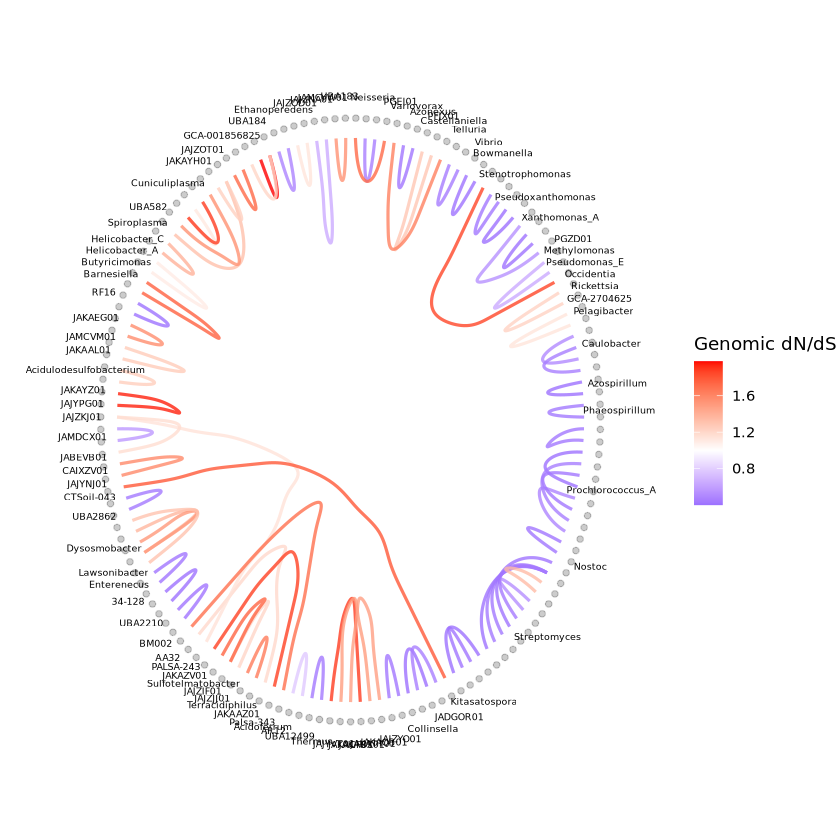

In [134]:
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(
    data = conn_data_frame, 
    alpha = 0.8, 
    width = 0.9, 
    aes(edge_colour = con.value)
  ) +
  geom_text(
    data = genus_centers,
    aes(
      x = center_x * 1.15,
      y = center_y * 1.15,
      label = genus
    ),
    size = 2,
    alpha = 1
  ) +
  geom_node_point(
    aes(
      filter = leaf,
      x = x * 1.07,
      y = y * 1.07
    ),
    alpha = 0.2
  ) +
  scale_edge_colour_gradient2(
    low = "blue",
    mid = "white",
    high = "red",
    midpoint = 1,
    name = "Genomic dN/dS"
  ) +
  scale_size_continuous(range = c(1, 3)) +
  theme_void() +
  theme(
    plot.margin = margin(t = 10, r = 10, b = 10, l = 10)  # ADD THIS
  ) +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))


In [93]:
#genome_coordinate_info

In [ ]:
# Stop here

In [132]:
vertices$angle <- 90 - 360 * vertices$id / nleaves
vertices$angle <- vertices$angle + 5  # Shift all by +5 degrees
vertices$hjust2 <- ifelse(vertices$angle < -90, 1, 0)
vertices$angle <- ifelse(vertices$angle < -90, vertices$angle + 180, vertices$angle)


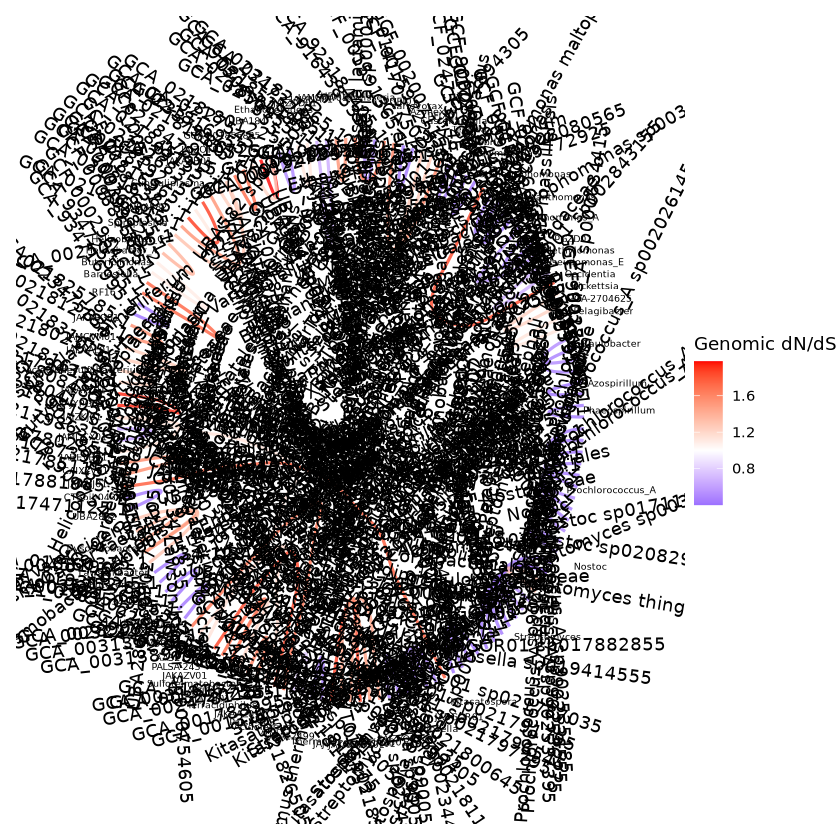

In [133]:
# — after computing vertices$id, vertices$angle, vertices$hjust —
V(mygraph)$angle <- vertices$angle
V(mygraph)$hjust2 <- vertices$hjust2

ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(
    data = conn_data_frame, 
    alpha = 0.8, 
    width = 0.9, 
    aes(edge_colour = con.value)
  ) +
  geom_text(
    data = genus_centers,
    aes(
      x = center_x * 1.15,
      y = center_y * 1.15,
      label = genus
    ),
    size = 2,
    alpha = 1
  ) +
  geom_node_point(
    aes(
      filter = leaf,
      x = x * 1.07,
      y = y * 1.07
    ),
    alpha = 0
  ) +
  geom_node_text(
    aes(
      label = name,
      angle = angle,  # <-- control rotation here
      hjust = hjust2   # <-- control horizontal alignment
  )
) +
  scale_edge_colour_gradient2(
    low = "blue",
    mid = "white",
    high = "red",
    midpoint = 1,
    name = "Genomic dN/dS"
  ) +
  scale_size_continuous(range = c(1, 3)) +
  theme_void() +
  theme(
    plot.margin = margin(t = 10, r = 10, b = 10, l = 10)  # ADD THIS
  ) +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))


In [129]:
# — after computing vertices$id, vertices$angle, vertices$hjust —
V(mygraph)$angle <- vertices$angle
V(mygraph)$hjust <- vertices$hjust

In [142]:
target  <- c("GCA_12345678.1", "GCA_87654321.1")

library(dplyr)
verts <- as_data_frame(mygraph, what="vertices")

label_df <- verts %>% 
  filter(name %in% target) %>% 
  # push them radially out a bit so they clear the circle
  mutate(
    x     = x * 1.07,
    y     = y * 1.07
    # angle & hjust should already be in verts if you injected 
    # them via V(mygraph)$angle etc.
  )

label_df

# after you calculate vertices$angle and vertices$hjust
V(mygraph)$angle <- vertices$angle
V(mygraph)$hjust <- vertices$hjust

label_df

ggraph(mygraph, layout = 'dendrogram', circular = TRUE) +
  geom_conn_bundle(
    data = conn_data_frame,
    aes(edge_colour = con.value),
    width = 0.9, alpha = 0.8
  ) +
  geom_node_point(
    aes(filter = leaf),
    alpha = 0.0  # hide all the dots if you like
  ) +
  # NOW draw only the two labels
  geom_text(
    data = label_df,
    aes(
      x     = x,
      y     = y,
      label = name,
      angle = angle,
      hjust = hjust
    ),
    size = 3,
    color = "black"
  ) +
  scale_edge_colour_gradient2(
    low      = "blue",
    mid      = "white",
    high     = "red",
    midpoint = 1,
    name     = "Genomic dN/dS"
  ) +
  theme_void() +
  theme(
    plot.margin = margin(10, 60, 10, 10)
  ) +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `x = x * 1.07`.
[1mCaused by error:[22m
[33m![39m object 'x' not found
